In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("/content/drive/MyDrive/exp56/hack/Complete-Dataset.zip (Unzipped Files)/Complete Dataset/Phising_Training_Dataset.zip (Unzipped Files)/Phising_Training_Dataset.csv")

In [2]:
df.head()

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,12344,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,12345,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,12346,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,12347,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,12348,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
#shuffling the dataset
df = df.sample(frac=1)

In [4]:
#splitting the dataset into X and y

#taking top 5 cols after doing feature selection
cols = ['having_Sub_Domain', 'port', 'HTTPS_token', 'web_traffic', 'URL_Length']
y = df['Result']
X = df[cols]

In [5]:
X.head()

,having_Sub_Domain,port,HTTPS_token,web_traffic,URL_Length
7238,1,-1,1,-1,-1
4698,0,1,1,-1,-1
2341,-1,1,1,1,-1
5294,1,1,1,0,-1
4829,0,1,1,1,-1


In [6]:
#train test split
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)

#logistic regression


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [17]:
lrclass = LogisticRegression(random_state=0)

param_grid = {
    "penalty": ['l2', 'none'],
    "class_weight":['balanced', None],
    "solver" :['newton-cg', 'lbfgs' , 'sag', 'saga'],
    "max_iter":[100,200,350,150],
    "multi_class":['auto', 'ovr', 'multinomial'],
    "warm_start":[True, False]

}


search = HalvingGridSearchCV(lrclass,param_grid,cv=10,
                             factor=4,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 40
max_resources_: 7164
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 384
n_resources: 40
Fitting 10 folds for each of 384 candidates, totalling 3840 fits


KeyboardInterrupt: ignored

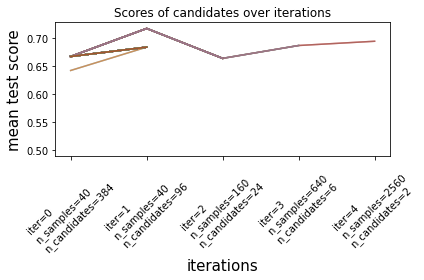

In [ ]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
best_model = search.best_params_

In [ ]:
search.cv_results_['params'][search.best_index_]

{'class_weight': 'balanced',
 'max_iter': 150,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'warm_start': True}

In [ ]:
search.best_score_

0.6938495710784314

In [ ]:
best_model = LogisticRegression(**search.best_params_)
best_model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=150,
                   multi_class='multinomial', warm_start=True)

In [ ]:
y_pred = best_model.predict(X_test)

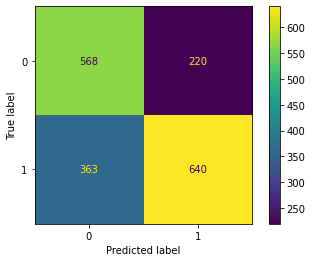

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.72      0.66       788
           1       0.74      0.64      0.69      1003

    accuracy                           0.67      1791
   macro avg       0.68      0.68      0.67      1791
weighted avg       0.69      0.67      0.68      1791



In [ ]:
y_train

6130    1
1852   -1
1054   -1
79      1
2811    1
       ..
5051   -1
4301    1
8056    1
2030    1
1794   -1
Name: Result, Length: 7164, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


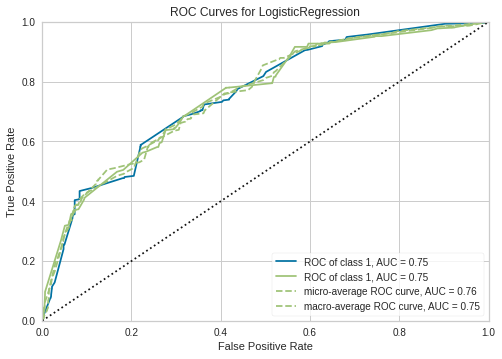

In [ ]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  


In [ ]:
y_test=y_test.replace(-1,0)
y_train=y_train.replace(-1,0)

#Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
dtclass = DecisionTreeClassifier(random_state=0)

param_grid = { "max_depth":[3,5,9,None],
              "min_samples_split":[2,5,10,25,100],
              "min_samples_leaf":[1,4,10,25,75],
              "max_features":['auto','sqrt','log2',None],
              "max_leaf_nodes":[20,50,100,None],
              "class_weight":['balanced',None],
}

search = HalvingGridSearchCV(dtclass,param_grid,cv=10,
                             factor=4,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 40
max_resources_: 7164
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 3200
n_resources: 40
Fitting 10 folds for each of 3200 candidates, totalling 32000 fits
----------
iter: 1
n_candidates: 800
n_resources: 40
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
----------
iter: 2
n_candidates: 200
n_resources: 40
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
----------
iter: 3
n_candidates: 50
n_resources: 160
Fitting 10 folds for each of 50 candidates, totalling 500 fits
----------
iter: 4
n_candidates: 13
n_resources: 640
Fitting 10 folds for each of 13 candidates, totalling 130 fits
----------
iter: 5
n_candidates: 4
n_resources: 2560
Fitting 10 folds for each of 4 candidates, totalling 40 fits


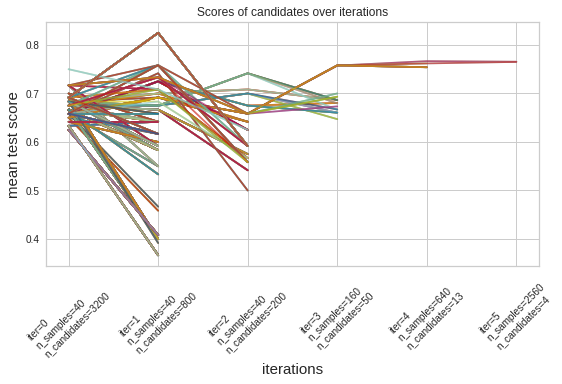

In [ ]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
best_model = search.best_params_

In [ ]:
search.cv_results_['params'][search.best_index_]

{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 10,
 'min_samples_split': 25}

In [ ]:
search.best_score_

0.765453431372549

In [ ]:
best_model = DecisionTreeClassifier(**search.best_params_)
best_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_leaf_nodes=50,
                       min_samples_leaf=10, min_samples_split=25)

In [ ]:
y_pred = best_model.predict(X_test)

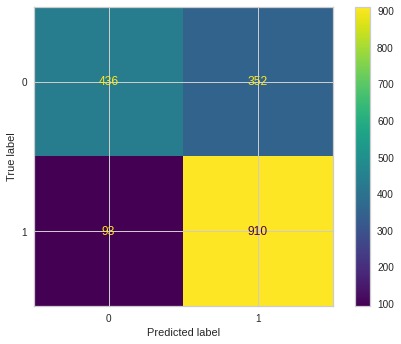

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66       788
           1       0.72      0.91      0.80      1003

    accuracy                           0.75      1791
   macro avg       0.77      0.73      0.73      1791
weighted avg       0.77      0.75      0.74      1791



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


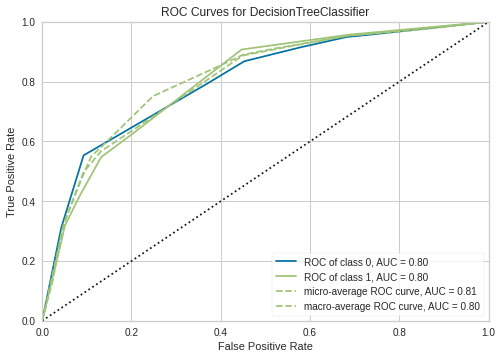

In [ ]:
visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  


#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
KNN = KNeighborsClassifier()

param_grid = {"n_neighbors":[3,4,5,7,10],
              "weights":['uniform','distance'],
              "algorithm":['auto','ball_tree','kd_tree',"brute"],
              "leaf_size":[10,20,30,50,70],
              "p":[1,2],
              "metric":['minkowski'],  # metric = "precomputed" cannot be used as for it X should be a square kernel matrix
              "n_jobs":[-1],
}

search = HalvingGridSearchCV(KNN,param_grid,cv=10,
                             factor=5,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 57
max_resources_: 7164
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 400
n_resources: 57
Fitting 10 folds for each of 400 candidates, totalling 4000 fits
----------
iter: 1
n_candidates: 80
n_resources: 285
Fitting 10 folds for each of 80 candidates, totalling 800 fits
----------
iter: 2
n_candidates: 16
n_resources: 1425
Fitting 10 folds for each of 16 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 4
n_resources: 7125
Fitting 10 folds for each of 4 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print(search.best_params_)
print(search.best_score_)

{'algorithm': 'brute', 'leaf_size': 50, 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.758851269363506


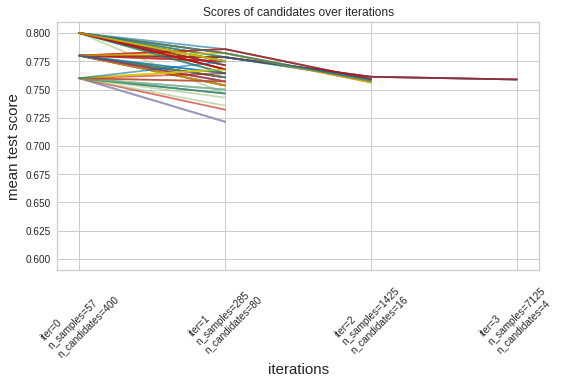

In [ ]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
best_model = search.best_params_

In [ ]:
search.cv_results_['params'][search.best_index_]

{'algorithm': 'brute',
 'leaf_size': 50,
 'metric': 'minkowski',
 'n_jobs': -1,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'distance'}

In [ ]:
best_model = KNeighborsClassifier(**search.best_params_)
best_model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=50, n_jobs=-1, n_neighbors=7,
                     p=1, weights='distance')

In [ ]:
y_pred = best_model.predict(X_test)

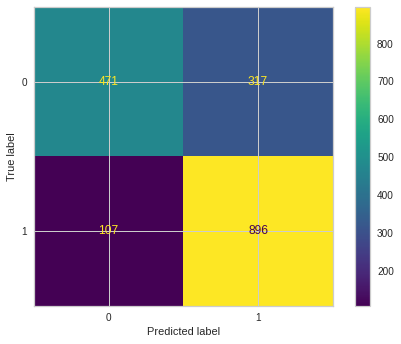

In [ ]:

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       788
           1       0.74      0.89      0.81      1003

    accuracy                           0.76      1791
   macro avg       0.78      0.75      0.75      1791
weighted avg       0.77      0.76      0.76      1791



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


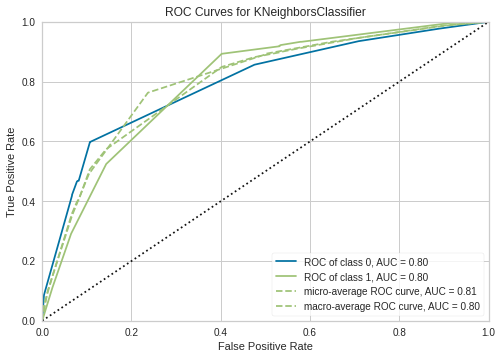

In [ ]:
visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  


#SVM

In [ ]:
from sklearn.svm import SVC


In [ ]:
SupportVM = SVC()

param_grid = {"kernel":['rbf','poly'],
              "C":[0.001 ,0.007, 0.01 , 0.1 ,1,4,10,100],
              "degree":[3,5,7,10],
              "probability":[True,False],
              "gamma":['auto','scale'],
              "class_weight":['balanced'],
              'verbose':[2],
              "break_ties":[True,False]
}

search = HalvingGridSearchCV(SupportVM,param_grid,cv=10,
                             factor=5,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 57
max_resources_: 7164
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 512
n_resources: 57
Fitting 10 folds for each of 512 candidates, totalling 5120 fits
----------
iter: 1
n_candidates: 103
n_resources: 285
Fitting 10 folds for each of 103 candidates, totalling 1030 fits
----------
iter: 2
n_candidates: 21
n_resources: 1425
Fitting 10 folds for each of 21 candidates, totalling 210 fits
----------
iter: 3
n_candidates: 5
n_resources: 7125
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[LibSVM]

In [ ]:
print(search.best_params_)
print(search.best_score_)

{'C': 1, 'break_ties': False, 'class_weight': 'balanced', 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False, 'verbose': 2}
0.7699337740517201


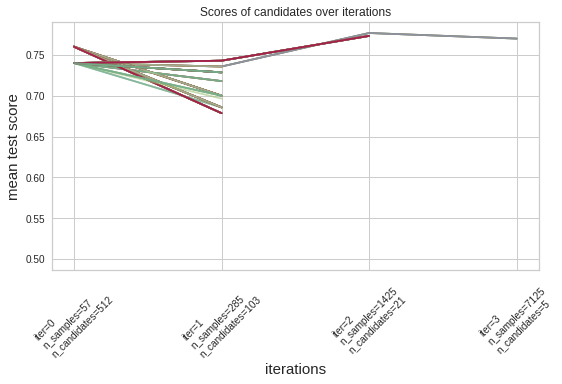

In [ ]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
best_model = SVC(**search.best_params_)
best_model.fit(X_train,y_train)

[LibSVM]

SVC(C=1, class_weight='balanced', degree=5, verbose=2)

In [ ]:
y_pred = best_model.predict(X_test)

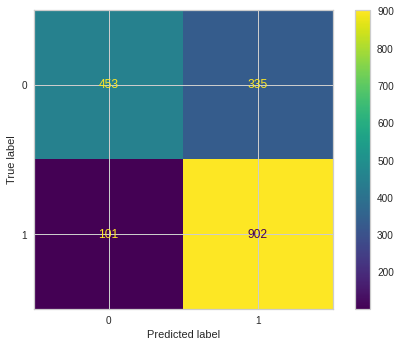

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.57      0.68       788
           1       0.73      0.90      0.81      1003

    accuracy                           0.76      1791
   macro avg       0.77      0.74      0.74      1791
weighted avg       0.77      0.76      0.75      1791



In [ ]:
visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


ModelError: ignored

#Randomforest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
RFclass = RandomForestClassifier(random_state=0)

param_grid = {"n_estimators":[100,250,500,1000],
              "max_depth":[3,10,25,60],
              "max_features":['auto','sqrt','log2',None],
        
}

search = HalvingGridSearchCV(RFclass,param_grid,cv=10,
                             factor=5,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 286
max_resources_: 7164
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 64
n_resources: 286
Fitting 10 folds for each of 64 candidates, totalling 640 fits
----------
iter: 1
n_candidates: 13
n_resources: 1430
Fitting 10 folds for each of 13 candidates, totalling 130 fits
----------
iter: 2
n_candidates: 3
n_resources: 7150
Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [ ]:
print(search.best_params_)
print(search.best_score_)

{'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500}
0.7674995592642653


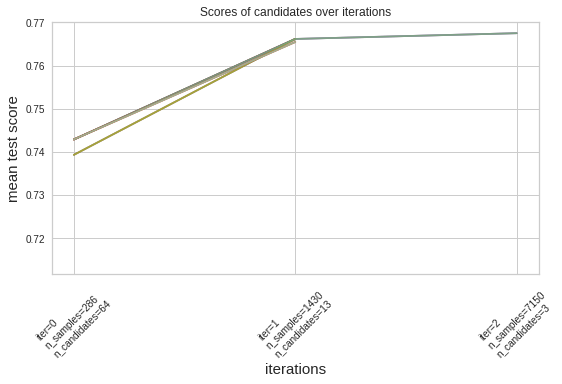

In [ ]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
best_model = RandomForestClassifier(**search.best_params_)
best_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=500)

In [ ]:
y_pred = best_model.predict(X_test)

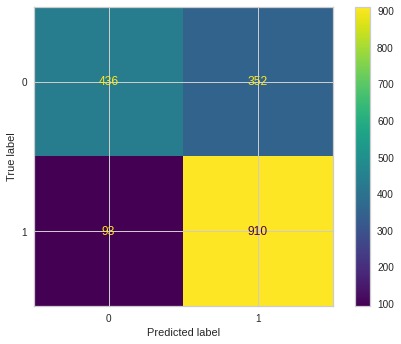

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66       788
           1       0.72      0.91      0.80      1003

    accuracy                           0.75      1791
   macro avg       0.77      0.73      0.73      1791
weighted avg       0.77      0.75      0.74      1791



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


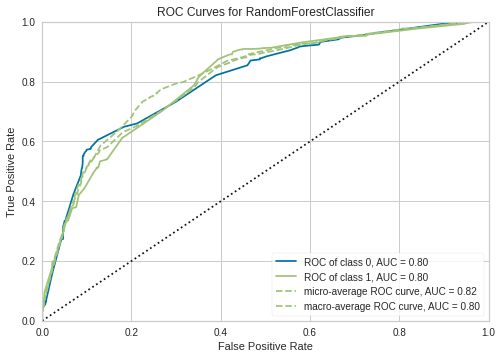

In [ ]:
visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  


#RF2

In [ ]:
RFclass = RandomForestClassifier(random_state=0)

param_grid = {"n_estimators":[100,250,500,1000],
              "max_depth":[3,10,25,60],
              "min_samples_split":[2,10,55,100],
              "min_samples_leaf":[1,4,10,25,75],
              "max_features":['auto','sqrt','log2',None],
        
}

search = HalvingGridSearchCV(RFclass,param_grid,cv=10,
                             factor=5,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)



n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 40
max_resources_: 7164
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 1280
n_resources: 40
Fitting 10 folds for each of 1280 candidates, totalling 12800 fits


#XGboost classifier


In [7]:
import xgboost

In [11]:
xg = xgboost.XGBClassifier(random_state=0)

param_grid = { "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                "max_depth"        : [ 3, 6, 8, 12, 15],
                "min_child_weight" : [ 1, 3, 5, 7 ],
                "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        
}

search = HalvingGridSearchCV(xg,param_grid,cv=10,
                             factor=5,aggressive_elimination=True,
                             return_train_score=True,n_jobs=-1,verbose=2).fit(X_train,y_train)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 40
max_resources_: 7164
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 2400
n_resources: 40
Fitting 10 folds for each of 2400 candidates, totalling 24000 fits
----------
iter: 1
n_candidates: 480
n_resources: 40
Fitting 10 folds for each of 480 candidates, totalling 4800 fits
----------
iter: 2
n_candidates: 96
n_resources: 200
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 3
n_candidates: 20
n_resources: 1000
Fitting 10 folds for each of 20 candidates, totalling 200 fits
----------
iter: 4
n_candidates: 4
n_resources: 5000
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [12]:
print(search.best_params_)
print(search.best_score_)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 15, 'min_child_weight': 3}
0.7659274549098196


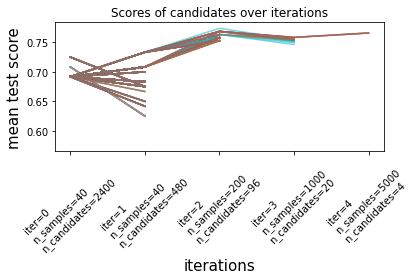

In [13]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [14]:
best_model = xgboost.XGBClassifier(**search.best_params_)
best_model.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=15,
              min_child_weight=3)

In [15]:
y_pred = best_model.predict(X_test)

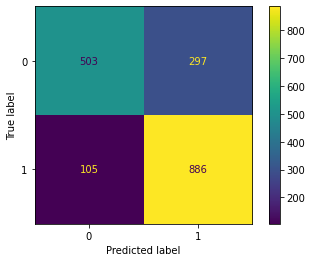

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [20]:
from sklearn import metrics

print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.63      0.71       800
           1       0.75      0.89      0.82       991

    accuracy                           0.78      1791
   macro avg       0.79      0.76      0.76      1791
weighted avg       0.78      0.78      0.77      1791



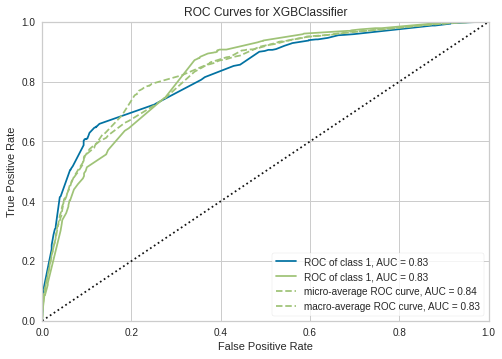

In [24]:
from yellowbrick.classifier import ROCAUC

y_test=y_test.replace(-1,0)
y_train=y_train.replace(-1,0)

visualizer = ROCAUC(best_model, classes=[0, 1])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  
